In [ ]:
# Overleaf
# https://www.overleaf.com/9836375457csrqydskhcmj

# Init

In [1]:
# Libraries
import numpy as np
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt

In [74]:
# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0
M = 100_000

# Monte Carlo

In [116]:
# !
# Should we only work in B-S world?
# !

# Finds value of an underlying at strike
def mc_value(S0, r, sigma, T, M):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())
        results[i] = S
    return results

# Finds value of option at strike
def mc_payoff(K, results, call, payoff_type):
    # Find option payoffs
    if payoff_type == "vanilla":
        if call:
            V = np.maximum(results - K, 0)
        else:
            V = np.maximum(K - results, 0)
    if payoff_type == "digital":
        if call:
            V = np.maximum(results - K, 0)
            V[V != 0] = 1
        else:
            V = np.maximum(K - results, 0)
            V[V != 0] = 1
    return V

# Finding Fair Value from Monte Carlo Simulation
mc_values = mc_value(S0, r, sigma, T, M)
mc_payoffs = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_payoffs)     # We have to discount the payoffs to calculate fair option's price
print(f"Option price: {option_price:.4f}")

# Finding Confidence Interval
standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
t_stat = np.abs(norm.ppf(0.025))
margin_of_error = t_stat * standard_error
lower_bound = option_price - margin_of_error
upper_bound = option_price + margin_of_error
print(f"Standard error: {standard_error:.4f}")
print(f"95% Confidence interval: ({lower_bound:.4f}, {upper_bound:.4f})")


Option price: 0.5653
Standard error: 0.0005
95% Confidence interval: (0.5644, 0.5663)


In [117]:
# Black-Scholes Option Pricing Functions
def d1_d2(S0, K, r, sigma, T):
    d1 = (log(S0/K) + (r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return d1,d2

def call_option_price(S0, K, r, T, d1, d2):
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

def put_option_price(S0, K, r, T, d1,d2):
    return K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


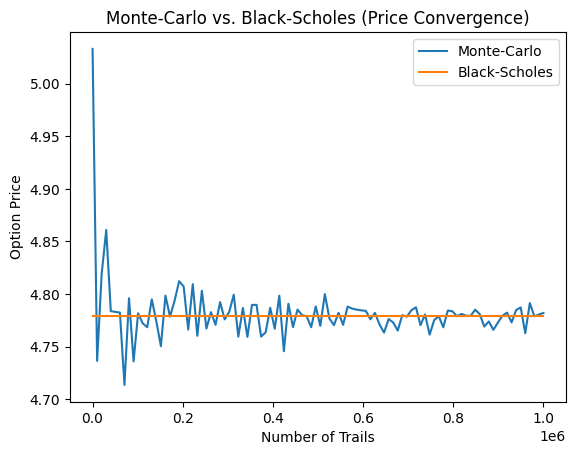

In [119]:
'''
-----------------------
| Convergence Studies |
-----------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Compare Monte-Carlo Option Price with Black-Scholes Option Price 
        for different number of trails (N) and calculate the absolute error.
        Then plot the put option's price for Monte-Carlo and Black-Scholes,
        along with the absolute error.
'''

from tqdm import tqdm

# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0

# Black-Scholes Option Price
d1, d2 = d1_d2(S0, K, r, sigma, T)
bs_answer = put_option_price(S0, K, r, T, d1, d2)

option_prices = []   # List containing average option price of each trail
abs_errors = []      # List containing absolute error of each trail

# List containing number of trails
trails = np.linspace(100, 1_000_000, 100, dtype=int)

for M in tqdm(trails):
    values_at_expiration = []  # Stock prices at expiration
    option_prices_at_expiration = [] # Option prices at expiration

    # Get stock price development
    values_history = mc_value(S0, r, sigma, T, M)
    values_at_expiration.append(values_history[-1])

    # Get option price development
    payoff_history = mc_payoff(K, values_history, call=False, payoff_type='vanilla')
    option_price = np.exp(-r * T) * np.mean(payoff_history) # We have to discount the payoffs to calculate fair option's price
    option_prices_at_expiration.append(option_price)

    # Get average option price
    option_prices.append(np.mean(option_prices_at_expiration))

    # Get absolute error
    abs_errors.append(np.abs(np.mean(option_prices_at_expiration) - bs_answer))

# Plotting
plt.title("Monte-Carlo vs. Black-Scholes (Price Convergence)")
plt.plot(trails, option_prices, label="Monte-Carlo")                                 # Plot Monte-Carlo option price development 
plt.plot(trails, [bs_answer for i in range(len(trails))], label="Black-Scholes")    # Plot Black-Scholes option price development
# plt.plot(trails, abs_errors, label="Absolute Error")                                # Plot Absolute Error for N trails (Monte-Carlo vs. Black-Scholes)
plt.xlabel("Number of Trails")
plt.ylabel("Option Price")
plt.legend()


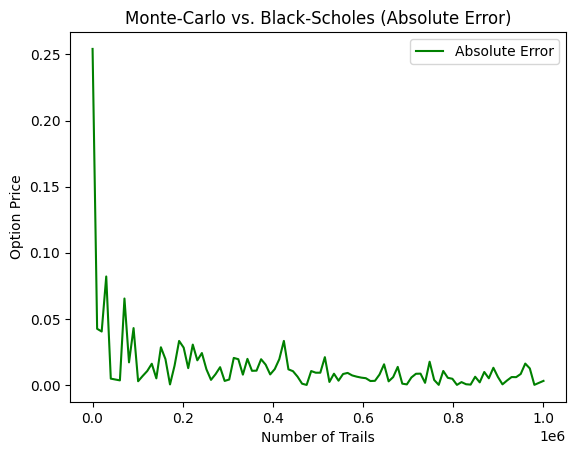

In [120]:
plt.title("Monte-Carlo vs. Black-Scholes (Absolute Error)")
plt.plot(trails, abs_errors, label="Absolute Error", c='g')    
plt.xlabel("Number of Trails")
plt.ylabel("Option Price")
plt.legend()                            # Plot Absolute Error for N trails (Monte-Carlo vs. Black-Scholes)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


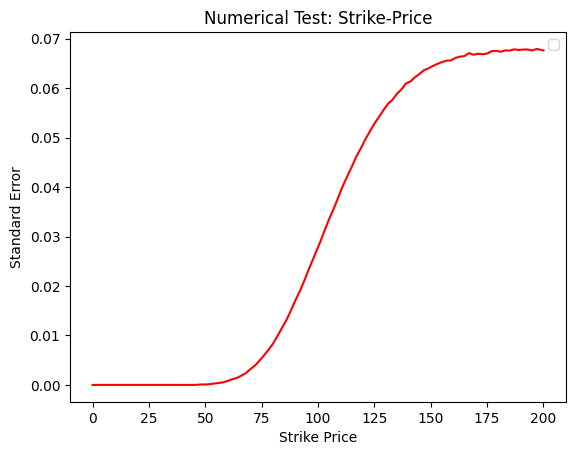

In [123]:
'''
---------------------------------
| Numerical Test (Strike-Price) |
---------------------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Calculate the option price for different strike prices
        with Monte-Carlo method and determine standard error.
'''

# Option Characteristics
S0 = 100
strike_prices = np.linspace(0, 200, 100, dtype=int)
r = 0.06
sigma = 0.2
T = 1.0

M = 100_000     # Time discretization

std_errs = []   # List containing standard error of each strike price

for K in strike_prices:
    # Get underlying value development
    mc_values = mc_value(S0, r, sigma, T, M)
    # Get option price development
    mc_payoffs = mc_payoff(K, mc_values, call=False, payoff_type='vanilla')
    # Get fair option price
    option_price = np.exp(-r * T) * np.mean(mc_payoffs)

    # Calculate standard error
    standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
    std_errs.append(standard_error)

plt.title("Numerical Test: Strike-Price")
plt.plot(strike_prices, std_errs, c='r')
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


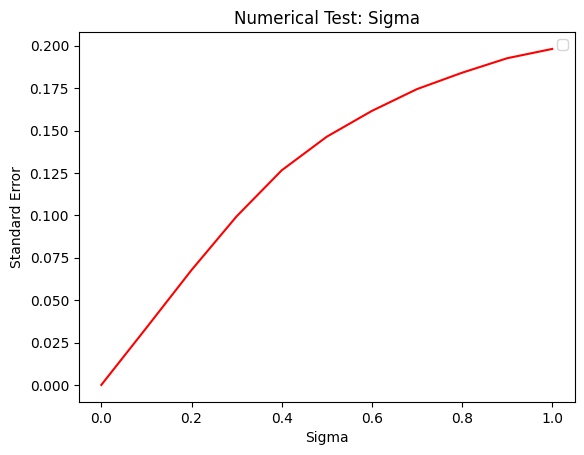

In [124]:
'''
--------------------------
| Numerical Test (Sigma) |
--------------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Calculate the option price for different sigmas with
        Monte-Carlo method and determine standard error.
'''

# Option Characteristics
S0 = 100
strike_prices = 99
r = 0.06
sigmas = np.linspace(0.0, 1.0, 11, dtype=float)
T = 1.0

M = 100_000     # Time discretization

std_errs = []   # List containing standard error for each sigma

for sigma in sigmas:
    # Get underlying value development
    mc_values = mc_value(S0, r, sigma, T, M)
    # Get option price development
    mc_payoffs = mc_payoff(K, mc_values, call=False, payoff_type='vanilla')
    # Get fair option price
    option_price = np.exp(-r * T) * np.mean(mc_payoffs)
    
    # Calculate standard error
    standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
    std_errs.append(standard_error)

plt.title("Numerical Test: Sigma")
plt.plot(sigmas, std_errs, c='r')
plt.xlabel("Sigma")
plt.ylabel("Standard Error")
plt.legend()


# Approximating Delta

Should run each test for multiple times and show the confidence interval of deviation. With seed is much more stable

In [ ]:
# Modified MC to support given random Z distribution values

def mc_value_seed(S0, r, sigma, T, M, Z):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z[i])
        results[i] = S
    return results

In [ ]:
# Finite Difference Method (with one side difference)

# Finding New Prices
finite_difference_step = 10.0            # Is not stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_delta, r, sigma, T, M)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

In [ ]:
# Finite Difference Method (with one side difference and fixed seed)

# Setting seed and generating values
np.random.seed(np.random.randint(1000))
Z = np.random.normal(0, 1, M)

# Finding New Prices
finite_difference_step = 0.1            # Is much more stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value_seed(S0, r, sigma, T, M, Z)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value_seed(S_delta, r, sigma, T, M, Z)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

In [ ]:
# Finite Difference Method (With Lower and Higher)
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf - Notes on convergence

# Finding New Prices
finite_difference_step = 0.1
S_delta = S0 * finite_difference_step
S_up = S0 + S_delta
S_down = S0 - S_delta

# Finding Approxiamation for Higher Price
mc_values = mc_value(S_up, r, sigma, T, M)
mc_results_up = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_up = np.exp(-r * T) * np.mean(mc_results_up)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_down, r, sigma, T, M)
mc_results_down = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_down = np.exp(-r * T) * np.mean(mc_results_down)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_up - option_price_down) / (2 * S_delta)

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

# Sophisticated methods for approximating Delta

In [ ]:
# Some material used:
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf
# https://people.maths.ox.ac.uk/gilesm/mc/module_6/adjoints/adjoints.pdf    # Not very useful
# https://math.maths.univ-evry.fr/kahmed/Lecture7.pdf                       # Not used
# https://github.com/Redmek/Pricing-and-Hedging-of-Exotic-Options-Under-Black-Scholes-and-Heston-Models/blob/main/Pricing_exotic_options.ipynb
# http://arno.uvt.nl/show.cgi?fid=146124        # Might be usefull for report

In [ ]:
# Pathwise for Vanilla Option (Does not work with digital)
# https://quant.stackexchange.com/questions/33695/pathwise-derivative-to-estimate-delta

# Monte Carlo
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
# Finding distribution of results
I = [1 if i != 0 else 0 for i in mc_results]            # DID I UNDERSTOOD IT CORRECTLY?
deltas = np.exp(-r * T)*(mc_values/S0)*mc_results
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

In [ ]:
# Pathwise for Smoothed

mc_values = mc_value(S0, r, sigma, T, M)

# !
# Ask how and why it is supposedly works. Also where I can read about all of this in greater detail
# !

# The digital option is essentially an indicator function with jump at K, and hence the derivative in K does not exist.
# We approximate the option payoff with a smooth function (normal-cdf with small variance)
# We use a sigmoid here to approximate the indicator function
def sigmoid(K, values): 
  result =  1/(1+np.exp(-values + K))
  return result

# Derivative of our indicator proxy referencing the underlying x
def digital_sigmoid(K, values):
  result = sigmoid(K, values) * (1 - sigmoid(K, values))
  return result

I = digital_sigmoid(K, mc_values)
deltas = np.exp(-r * T)*(mc_values/S0)*I
    
#Test
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

In [ ]:
# Likelihood for Vanilla and Digital Option
# https://github.com/hongwai1920/Implement-Option-Pricing-Model-using-Python
# https://nbviewer.org/github/hongwai1920/Implement-Option-Pricing-Model-using-Python/blob/master/2.%20digital%20Greeks%20using%20finite%20difference%2C%20pathwise%20derivative%20estimate%20and%20likelihood%20ratio%20methods.ipynb
# And the paper on Canvas

# Monte Carlo
ST = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, ST, call = True, payoff_type = "digital")     # Change to digital to find digital option, it just makes mc_results to 0 and 1, thus I

# Calculating Delta with Likelihood method
Z = (np.log( ST / S0 ) - (r - 0.5 * sigma**2) * T) / (S0 * sigma**2 * T)
deltas = np.exp(-r * T) * mc_results * Z

print(f"Delta approximation with Likelihood: {np.mean(deltas):.4f}")

!

Should we add more greeks?

!

# Asian Option

In [ ]:
def d1_d2(S0, K, r, sigma, T):
    d1 = (log(S0/K) + (r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return d1,d2
def european_call_option_price(S0, K, r, T, d1, d2):
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)


def asian_call_option_price(S0, N,sigma,K,r, T):
    '''
    :param S0: initial stock price
    :param N: Number of observations
    :param sigma: volatility
    :param K: strike price
    :param r: interest rate
    :param T: maturity time
    :return: asian option price
    '''
    asian_sigma = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    asian_risk_free_interest = 0.5*((r-0.5*sigma**2) + asian_sigma**2)
    d1,d2=d1_d2(S0,K,asian_risk_free_interest, asian_sigma, T)
    A_N = european_call_option_price(S0, K,asian_risk_free_interest, T,d1, d2)
    return A_N

In [ ]:
N = 3650
asian_option_price = asian_call_option_price(S0, N,sigma, K, r,T)
print(f"Asian Option price: {asian_option_price:.4f}")
all_n_vals = []
option_prices = []
for i in range(N):
    option_prices.append(asian_call_option_price(S0, i,sigma, K, r,T))
    all_n_vals.append(i)
    
plt.plot(all_n_vals,option_prices)
plt.grid()
plt.xlabel("Number of Steps used in Calculation (N)")
plt.ylabel("Asian Option Price")
plt.show()